In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl
import pandas as pd

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.226, Omega_b = 0.0455, h = 0.7, sigma8 = 0.810, n_s = 0.967, matter_power_spectrum='linear')
h     = cosmo.cosmo.params.h

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

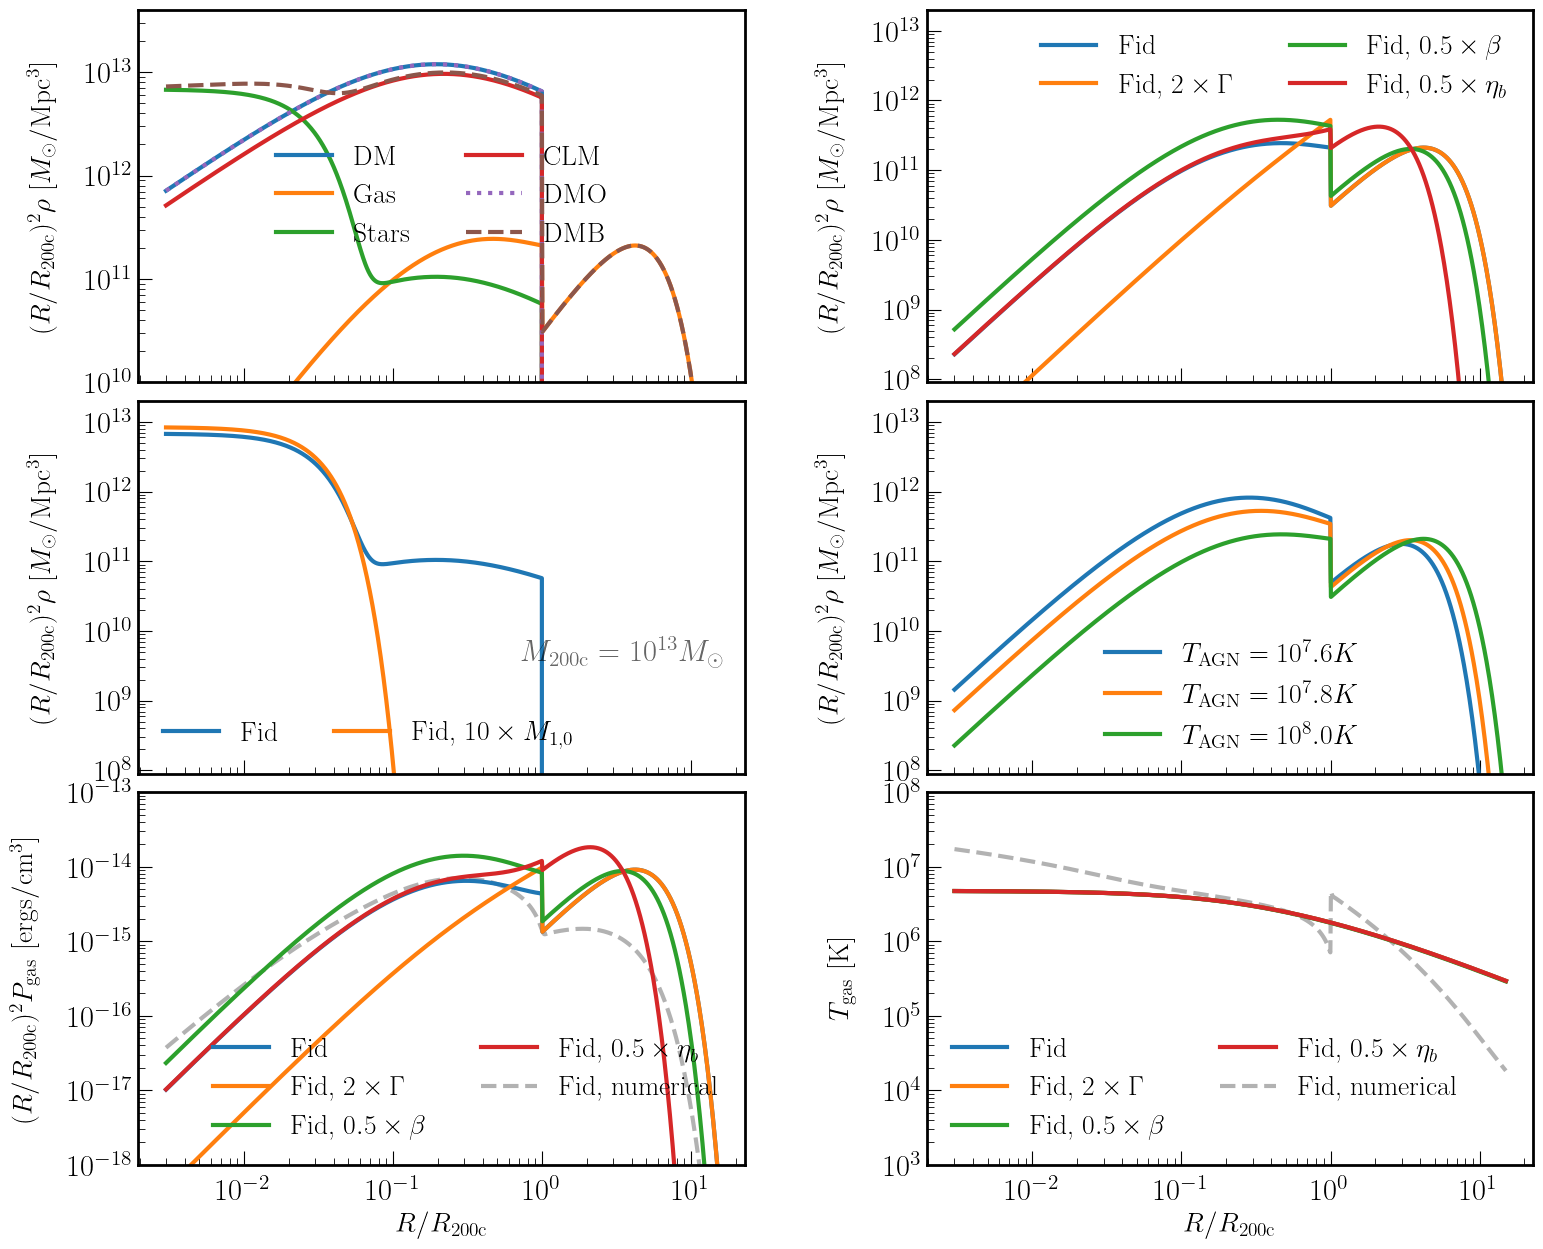

In [3]:
fig, ax = plt.subplots(3, 2, figsize = (18, 15), sharex = True, sharey = False)
plt.subplots_adjust(hspace = 0.05, wspace = 0.3)
[a.set_xscale('log') for a in ax.flat]
[a.set_yscale('log') for a in ax.flat]

#Load the default params, provided in Table 2 of https://arxiv.org/pdf/2005.00009
#This uses the best-fit from the matter and pressure fields. Swap the _Mpr with
#the _All to get params for joint fits to gas, star, density, and pressure field
bpar = bfg.Profiles.Mead20.Params_TAGN_8p0_MPr

#convenience function to give new dictionary with just one param changed
def bpar_new(p, bpar = bpar):
    return {k:v for k,v in bpar.items() if k != p}

#Init the profiles using dictionary of params
DM  = bfg.Profiles.Mead20.DarkMatter(**bpar)
GAS = bfg.Profiles.Mead20.Gas(**bpar)
STR = bfg.Profiles.Mead20.Stars(**bpar)
CLM = bfg.Profiles.Mead20.CollisionlessMatter(**bpar)
DMO = bfg.Profiles.Mead20.DarkMatterOnly(**bpar)
DMB = bfg.Profiles.Mead20.DarkMatterBaryon(**bpar)

#In addition the pressure/temperature defined in Arico++ (which we use blow)
#We also show the numerically integrated profiles, which are obtained by
#using hydrostatic equilibrium alone (as done in https://arxiv.org/abs/2409.03822 for example)
BND = bfg.Profiles.Mead20.Gas(**bpar)
PRS = bfg.Profiles.Pressure(gas = BND, darkmatterbaryon = DMB)
nGS = bfg.Profiles.GasNumberDensity(gas = BND, mean_molecular_weight = 0.59)
TMP = bfg.Profiles.Temperature(pressure = PRS, gasnumberdensity = nGS)

#Pick a mass, in Msun
M = 1e13
a = 1 #scale factor
R200c = ccl.halos.massdef.MassDef200c.get_radius(cosmo, M, a)
R = np.geomspace(0.003 * R200c, 15 * R200c, 1000)
x = R/R200c
mdef = ccl.halos.massdef.MassDef200c


#First plot fiducial dist
ax.flat[0].plot(x, x**2 * DM.real(cosmo, R, np.array(M), a), lw = 3,  label = 'DM')
ax.flat[0].plot(x, x**2 * GAS.real(cosmo, R, np.array(M), a), lw = 3, label = 'Gas')
ax.flat[0].plot(x, x**2 * STR.real(cosmo, R, np.array(M), a), lw = 3, label = 'Stars')
ax.flat[0].plot(x, x**2 * CLM.real(cosmo, R, np.array(M), a), lw = 3, label = 'CLM')
ax.flat[0].plot(x, x**2 * DMO.real(cosmo, R, np.array(M), a), lw = 3, ls = ':', label = 'DMO')
ax.flat[0].plot(x, x**2 * DMB.real(cosmo, R, np.array(M), a), lw = 3, ls = '--', label = 'DMB')
ax.flat[0].set_ylim(1e10, 4e13)


#Now the gas variations
ax.flat[1].plot(x, x**2 * GAS.real(cosmo, R, np.array(M), a), lw = 3, label = 'Fid')
ax.flat[1].plot(x, x**2 * bfg.Profiles.Mead20.Gas(**bpar_new('Gamma'), Gamma = 2.2).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $2\times\Gamma$')
ax.flat[1].plot(x, x**2 * bfg.Profiles.Mead20.Gas(**bpar_new('beta'),  beta = 0.3).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.5\times\beta$')
ax.flat[1].plot(x, x**2 * bfg.Profiles.Mead20.Gas(**bpar_new('eta_b'), eta_b = 0.25).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.5\times \eta_b$')
ax.flat[1].set_ylim(9e7, 2e13)

#Now the star variations
ax.flat[2].plot(x, x**2 * STR.real(cosmo, R, np.array(M), a), lw = 3, label = 'Fid')
ax.flat[2].plot(x, x**2 * bfg.Profiles.Mead20.Stars(**bpar_new('M_star'), M_star = 2.2e13/h * 2).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $10 \times M_{1, 0}$')
ax.flat[2].set_ylim(9e7, 2e13)

#Now the TAGN ones variations
ax.flat[3].plot(x, x**2 * bfg.Profiles.Mead20.Gas(**bfg.Profiles.Mead20.Params_TAGN_7p6_MPr).real(cosmo, R, np.array(M), a), lw = 3, label = r'$T_{\rm AGN} = 10^7.6 K$')
ax.flat[3].plot(x, x**2 * bfg.Profiles.Mead20.Gas(**bfg.Profiles.Mead20.Params_TAGN_7p8_MPr).real(cosmo, R, np.array(M), a), lw = 3, label = r'$T_{\rm AGN} = 10^7.8 K$')
ax.flat[3].plot(x, x**2 * bfg.Profiles.Mead20.Gas(**bfg.Profiles.Mead20.Params_TAGN_8p0_MPr).real(cosmo, R, np.array(M), a), lw = 3, label = r'$T_{\rm AGN} = 10^8.0 K$')
ax.flat[3].set_ylim(9e7, 2e13)

#Now the pressure profiles
ax.flat[4].plot(x, x**2 * bfg.Profiles.Mead20.Pressure(**bpar).real(cosmo, R, np.array(M), a), lw = 3, label = 'Fid')
ax.flat[4].plot(x, x**2 * bfg.Profiles.Mead20.Pressure(**bpar_new('Gamma'), Gamma = 2.2).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $2\times\Gamma$')
ax.flat[4].plot(x, x**2 * bfg.Profiles.Mead20.Pressure(**bpar_new('beta'),  beta = 0.3).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.5\times\beta$')
ax.flat[4].plot(x, x**2 * bfg.Profiles.Mead20.Pressure(**bpar_new('eta_b'), eta_b = 0.25).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.5\times \eta_b$')
ax.flat[4].plot(x, x**2 * PRS.real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, numerical', color = 'k', ls = '--', alpha = 0.3, zorder = -100)
ax.flat[4].set_ylim(1e-18, 1e-13)

#All the temperature lines (except the last one, which is a numerical solution)
#overlap one-another, as the model only depends on alpha and r_s. And none of the gas parameters.
ax.flat[5].plot(x, bfg.Profiles.Mead20.Temperature(**bpar).real(cosmo, R, np.array(M), a), lw = 3, label = 'Fid')
ax.flat[5].plot(x, bfg.Profiles.Mead20.Temperature(**bpar_new('Gamma'), Gamma = 2.2).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $2\times\Gamma$')
ax.flat[5].plot(x, bfg.Profiles.Mead20.Temperature(**bpar_new('beta'),  beta = 0.3).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.5\times\beta$')
ax.flat[5].plot(x, bfg.Profiles.Mead20.Temperature(**bpar_new('eta_b'), eta_b = 0.25).real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, $0.5\times \eta_b$')
ax.flat[5].plot(x, TMP.real(cosmo, R, np.array(M), a), lw = 3, label = r'Fid, numerical', color = 'k', ls = '--', alpha = 0.3, zorder = -100)
ax.flat[5].set_ylim(1e3, 1e8)

ax[0, 0].set_ylabel(r'$(R/R_{\rm 200c})^2\rho$  $[M_\odot/{\rm Mpc}^3]$', size = 20, labelpad = 20)
ax[0, 1].set_ylabel(r'$(R/R_{\rm 200c})^2\rho$  $[M_\odot/{\rm Mpc}^3]$', size = 20, labelpad = 20)
ax[1, 0].set_ylabel(r'$(R/R_{\rm 200c})^2\rho$  $[M_\odot/{\rm Mpc}^3]$', size = 20, labelpad = 20)
ax[1, 1].set_ylabel(r'$(R/R_{\rm 200c})^2\rho$  $[M_\odot/{\rm Mpc}^3]$', size = 20, labelpad = 20)
ax[2, 0].set_ylabel(r'$(R/R_{\rm 200c})^2 P_{\rm gas}$  $[\rm ergs/cm^3]$', size = 20, labelpad = 20)
ax[2, 1].set_ylabel(r'$T_{\rm gas}$  $[\rm K]$', size = 20, labelpad = 20)

ax[2, 0].set_xlabel(r'$R/R_{\rm 200c}$', size = 20)
ax[2, 1].set_xlabel(r'$R/R_{\rm 200c}$', size = 20)

ax[2, 0].tick_params(axis = 'x', pad = 10)
ax[2, 1].tick_params(axis = 'x', pad = 10)
ax[2, 0].text(0.63, 0.3, r'$M_{\rm 200c} = 10^{%d}M_\odot$' % int(np.log10(M)), size = 22,
              color = 'k', alpha = 0.6, ha = 'left', transform = ax[1, 0].transAxes)

[ax.flat[i].legend(fontsize = 20, frameon = False, ncol = 2) for i in range(6)]
ax.flat[3].legend(fontsize = 20, frameon = False, ncol = 1)

plt.show()

In [4]:
DMO = bfg.Profiles.Mead20.DarkMatterOnly(**bpar)
DMB = bfg.Profiles.Mead20.DarkMatterBaryon(**bpar)

Displacement = bfg.Baryonification3D(DMO, DMB, cosmo, N_int = 50_000)
Displacement.setup_interpolator(N_samples_z = 2, z_min = 0, z_max = 0.01, z_linear_sampling = True, 
                                R_min = 0.001, R_max = 20, N_samples_R = 10000,
                                M_min = 1e12, M_max = 1e16, N_samples_Mass = 5, Rdelta_sampling = True)

Building Table: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.02it/s]


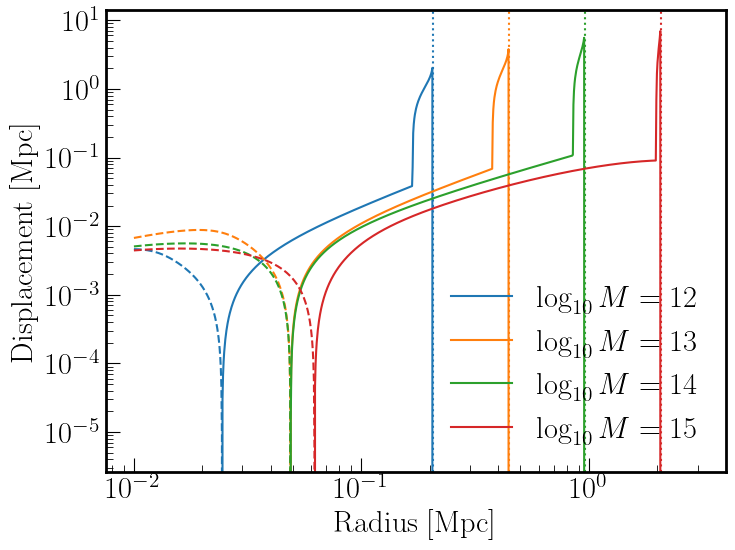

In [5]:
plt.figure(figsize = (8,6))
plt.xscale('log')
plt.yscale('log')
R = np.geomspace(1e-2, 3, 1000)
a = 1 #scale factor

for M in [1e12, 1e13, 1e14, 1e15]:
    R200c = ccl.halos.massdef.MassDef200c.get_radius(cosmo, M, a)
    c = plt.plot(R, Displacement.displacement(R, M, 1), label = r'$\log_{10}M = %d$' % np.log10(M))
    plt.plot(R, -Displacement.displacement(R, M, 1),color = c[0].get_color(), ls = '--')
    plt.axvline(R200c, color = c[0].get_color(), ls = ':')
    
plt.legend()
plt.xlabel('Radius [Mpc]')
plt.ylabel('Displacement [Mpc]')
plt.show()